In [46]:
# for calculation
import numpy as np
from osgeo import ogr
from osgeo import gdal
from osgeo import osr
from skimage.graph import route_through_array
from skimage.graph import MCP_Geometric
from rdp import rdp
import matplotlib.image as img

In [30]:
# only for visualization
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# Define datafiles and weights

In [31]:
RASTER_FILENAME = "rasters.tif"
COSTS_SURFACE_FILENAME = "output_cost_surface.tif"
SHAPEFILE_START_POINT = "rasters/Start.shp"
SHAPEFILE_DESTINATION_POINT = "rasters/Destination.shp"

#Therefore, random weights can be selected and assigned. The interval of the weights is 1 to 5
# we have 26 sample rasters merged into one with 26 bands
COSTS = 1 + 4 * np.random.random_sample((26,))

# Functions

### There is additional internal function required for functions 3 and 4

In [32]:
def function_points_on_raster(raster_filename,shapefiles):
    # get coordinates from shapefiles
    driverName = "ESRI Shapefile"
    drv = ogr.GetDriverByName( driverName )
    # shapefile driver is not available
    if drv is None:
        return
    driver = ogr.GetDriverByName(driverName)
    points = []
    for shapefile_name in shapefiles:
        # open shapefile readonly
        dataSource = driver.Open(shapefile_name, 0)
        # file is not found or it can't be opened
        if dataSource is None:
            return
        layer = dataSource.GetLayer()
        featureCount = layer.GetFeatureCount()
        # should be only one point
        if featureCount != 1:
            return
        feature = layer.GetFeature(0)
        geometry = feature.GetGeometryRef()
        points.append( (geometry.GetX(), geometry.GetY()) )
    #print "points",points
    
    # convert geo coordinates from shapefiles to array indices
    data_source_gdal = gdal.Open(raster_filename, gdal.GA_ReadOnly)
    # TODO: do you need some exeption here?
    if data_source_gdal is None:
        return
    geotransform = data_source_gdal.GetGeoTransform()
    origin_x = geotransform[0]
    origin_y = geotransform[3] 
    pixel_width = geotransform[1] 
    pixel_height = geotransform[5]
    points_idx = []
    for point in points:
        x = int((point[0] - origin_x)/pixel_width)
        y = int((point[1] - origin_y)/pixel_height)
        points_idx.append( (y,x) )
    #print "points_idx",points_idx
    return points_idx

function_points_on_raster(RASTER_FILENAME, [SHAPEFILE_START_POINT, SHAPEFILE_DESTINATION_POINT])

[(237, 163), (22, 94)]

# Function 1. Note: output may be saved to TIFF file if it's name defined

Function 1: Raster algebra to calculate cost surface. Raster data contain 2 values: on value of the cells and one value where no objects are located. The function has to work in a way that, independently from the number of the raster data located in a directory, it reads all of them and calculate the cost surface. Input and output of the functions and format of the data output are provided. The raster algebra algorithm is a weighted sum of all raster data where each raster is multiplied by one weight, whose value comes from another routine:
Cost surface raster = (ras_1*weight_1+ras_2* weight_2+ras_3*weight_3...)

In [33]:
def function1(raster_filename, costs_array, costs_filename=None):
    raster = gdal.Open(raster_filename, gdal.GA_ReadOnly)
    # TODO: do you need some exeption here?
    if raster is None:
        return
    raster_array = raster.ReadAsArray()
    cost_surface = (raster_array.reshape((raster_array.shape[0],-1)) 
                    * costs_array.reshape((-1,1))).reshape(raster_array.shape).sum(axis=0)
    
    if not costs_filename is None:
        # save cost surface array to TIFF file
        geotransform = raster.GetGeoTransform()
        originX = geotransform[0]
        originY = geotransform[3] 
        pixelWidth = geotransform[1] 
        pixelHeight = geotransform[5]
        cols = cost_surface.shape[1]
        rows = cost_surface.shape[0]

        driver = gdal.GetDriverByName("GTiff")
        outRaster = driver.Create(costs_filename, cols, rows, 1, gdal.GDT_UInt32)
        outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
        outband = outRaster.GetRasterBand(1)
        outband.WriteArray(cost_surface.astype(int))
        outRasterSRS = osr.SpatialReference()
        outRasterSRS.ImportFromWkt(raster.GetProjectionRef())
        outRaster.SetProjection(outRasterSRS.ExportToWkt())
        outband.FlushCache()
    
    return cost_surface

# Maybe used without output file name as
#cost_surface_array = function1(RASTER_FILENAME, COSTS)
cost_surface_array = function1(RASTER_FILENAME, COSTS, COSTS_SURFACE_FILENAME)

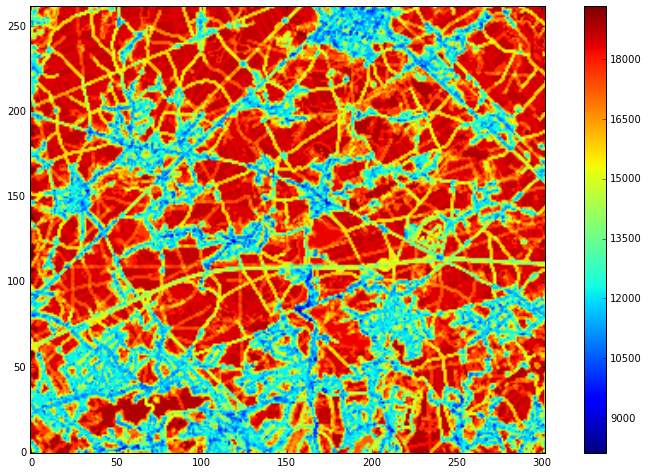

In [34]:
# plot the cost sufrace with pre-defined colormap 'jet'
plt.figure(figsize=(14,8))
plt.imshow(cost_surface_array, cmap='jet')
plt.gca().invert_yaxis()
plt.colorbar()

# Function 2

In [45]:
# save the cost sufrace as PNG with pre-defined colormap 'jet'
def function2(filename, array, cmap=None):
    if cmap is None:
        # set default palette
        cmap = 'jet'
    img.imsave(filename, np.flipud(array), cmap=cmap)
function2('cost_surface_array.png', cost_surface_array)

# Function 3

Function 3: Routing optimal path. Identification of optimal route + straightening to reduce zig-zags. Input and output of the functions and format of the data output are provided. The type of algorithm for routing will be discussed in detail.

## Version 1: required source rasters TIFF file and cost surface as array

In [36]:
def function3(raster_filename,cost_surface_array,shapefile_start_name,shapefile_destination_name,epsilon=0):
    # get coordinates from shapefiles and
    # convert geo coordinates from shapefiles to array indices
    points_idx = function_points_on_raster(raster_filename,[shapefile_start_name,shapefile_destination_name])
    
    # create path
    indices, weight = route_through_array(cost_surface_array, points_idx[0], points_idx[1], geometric=True, fully_connected=True)
    indices = np.array(indices).T
    #print "indices", indices
    #print "weight", weight
    
    if epsilon == 0:
        path_array = np.nan * np.empty_like(cost_surface_array)
        path_array[indices[0], indices[1]] = 1
        return path_array
    else:
        indices_smoothed = rdp(indices.reshape((-1),order='F').reshape((-1,2)), epsilon).reshape((-1))
        #print "indices_smoothed", indices_smoothed
        x0 = None
        y0 = None
        indices_smoothed_x = []
        indices_smoothed_y = []
        for (x,y) in indices_smoothed.reshape((-1,2)):
            if not x0 is None:
                #print x0,y0,"->",x,y
                if abs(x-x0) >= abs(y-y0):
                    scale = 1.*(y-y0)/(x-x0)
                    for xx in range(x0,x+(1 if x>x0 else -1),1 if x>x0 else -1):
                        yy = y0 + int(round(scale*(xx-x0)))
                        #print "xx", xx, yy
                        indices_smoothed_x.append(xx)
                        indices_smoothed_y.append(yy)
                    assert(xx==x and yy==y)
                else:
                    scale = 1.*(x-x0)/(y-y0)
                    for yy in range(y0,y+(1 if y>y0 else -1),1 if y>y0 else -1):
                        xx = x0 + int(round(scale*(yy-y0)))
                        #print "yy", xx, yy
                        indices_smoothed_x.append(xx)
                        indices_smoothed_y.append(yy)
                    assert(xx==x and yy==y)
            x0 = x
            y0 = y
        # add last point
        #print "end point",x,y
        path_array_smoothed = np.nan * np.empty_like(cost_surface_array)
        #path_array_smoothed[indices_smoothed[::2],indices_smoothed[1::2]] = 1
        path_array_smoothed[indices_smoothed_x,indices_smoothed_y] = 1
        return path_array_smoothed

# Use "epsilon" for Ramer-Douglas-Peucker algorithm (straightening to reduce zig-zags)
# https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm
# epsilon = 0 by default
path_array = function3(RASTER_FILENAME, cost_surface_array, SHAPEFILE_START_POINT, SHAPEFILE_DESTINATION_POINT)
path_array_simplified = function3(RASTER_FILENAME, cost_surface_array, SHAPEFILE_START_POINT, SHAPEFILE_DESTINATION_POINT, epsilon=5)

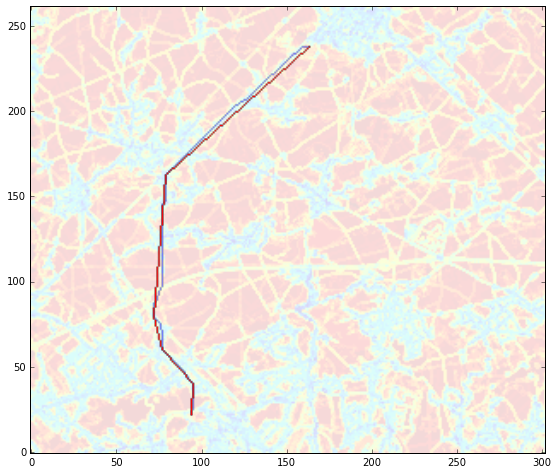

In [37]:
# plot results
plt.figure(figsize=(14,8))
plt.imshow(cost_surface_array, cmap='jet', alpha=0.15)
plt.imshow(path_array, cmap=colors.ListedColormap(['blue']), alpha=0.5)
plt.imshow(path_array_simplified, cmap=colors.ListedColormap(['red']))
plt.gca().invert_yaxis()

## Version 2: read cost surface from TIFF file

In [38]:
def function3v2(cost_surface_filename,shapefile_start_name,shapefile_destination_name,epsilon=0):
    raster = gdal.Open(cost_surface_filename, gdal.GA_ReadOnly)
    # TODO: do you need some exeption here?
    if raster is None:
        return
    cost_surface_array = raster.ReadAsArray()
    
    # get coordinates from shapefiles and
    # convert geo coordinates from shapefiles to array indices
    points_idx = function_points_on_raster(cost_surface_filename,[shapefile_start_name,shapefile_destination_name])
    
    # create path
    indices, weight = route_through_array(cost_surface_array, points_idx[0], points_idx[1], geometric=True, fully_connected=True)
    indices = np.array(indices).T
    #print "indices", indices
    #print "weight", weight
    
    if epsilon == 0:
        path_array = np.nan * np.empty_like(cost_surface_array)
        path_array[indices[0], indices[1]] = 1
        return path_array
    else:
        indices_smoothed = rdp(indices.reshape((-1),order='F').reshape((-1,2)), epsilon).reshape((-1))
        #print "indices_smoothed", indices_smoothed
        x0 = None
        y0 = None
        indices_smoothed_x = []
        indices_smoothed_y = []
        for (x,y) in indices_smoothed.reshape((-1,2)):
            if not x0 is None:
                #print x0,y0,"->",x,y
                if abs(x-x0) >= abs(y-y0):
                    scale = 1.*(y-y0)/(x-x0)
                    for xx in range(x0,x+(1 if x>x0 else -1),1 if x>x0 else -1):
                        yy = y0 + int(round(scale*(xx-x0)))
                        #print "xx", xx, yy
                        indices_smoothed_x.append(xx)
                        indices_smoothed_y.append(yy)
                    assert(xx==x and yy==y)
                else:
                    scale = 1.*(x-x0)/(y-y0)
                    for yy in range(y0,y+(1 if y>y0 else -1),1 if y>y0 else -1):
                        xx = x0 + int(round(scale*(yy-y0)))
                        #print "yy", xx, yy
                        indices_smoothed_x.append(xx)
                        indices_smoothed_y.append(yy)
                    assert(xx==x and yy==y)
            x0 = x
            y0 = y
        # add last point
        #print "end point",x,y
        path_array_smoothed = np.nan * np.empty_like(cost_surface_array)
        #path_array_smoothed[indices_smoothed[::2],indices_smoothed[1::2]] = 1
        path_array_smoothed[indices_smoothed_x,indices_smoothed_y] = 1
        return path_array_smoothed

# Use "epsilon" for Ramer-Douglas-Peucker algorithm (straightening to reduce zig-zags)
# https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm
# epsilon = 0 by default
path_array = function3v2(COSTS_SURFACE_FILENAME, SHAPEFILE_START_POINT, SHAPEFILE_DESTINATION_POINT)
path_array_simplified = function3v2(COSTS_SURFACE_FILENAME, SHAPEFILE_START_POINT, SHAPEFILE_DESTINATION_POINT, epsilon=5)

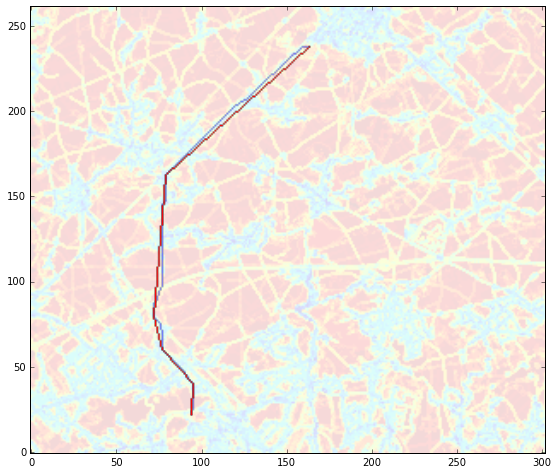

In [39]:
# plot results
plt.figure(figsize=(14,8))
plt.imshow(cost_surface_array, cmap='jet', alpha=0.15)
plt.imshow(path_array, cmap=colors.ListedColormap(['blue']), alpha=0.5)
plt.imshow(path_array_simplified, cmap=colors.ListedColormap(['red']))
plt.gca().invert_yaxis()

# Function 4

Function 4: Identification of corridors along the optimal route. The corridor encompasses all cells which are more expansive than the ones along the optimal route but within a certain threshold (e.g. not more “expansive than 5%).

In [40]:
def function4(raster_filename,cost_surface_array,shapefile_start_name,shapefile_destination_name, threshold):
        # get coordinates from shapefiles and
    # convert geo coordinates from shapefiles to array indices
    points_idx = function_points_on_raster(raster_filename,[shapefile_start_name,shapefile_destination_name])
    
    costs = np.zeros(cost_surface_array.shape)
    m = MCP_Geometric(cost_surface_array, fully_connected=True)
    costs_start,       traceback_array = m.find_costs([points_idx[0]])
    costs += costs_start
    costs_destination, traceback_array = m.find_costs([points_idx[1]])
    costs += costs_destination
    corridor_array = np.zeros(cost_surface_array.shape)
    idx = np.where(costs<=threshold*np.min(costs))
    corridor_array[idx] = 1
    return (corridor_array,costs)
    

# threshold = 5% (1.05)
(corridor_array,costs) = function4(RASTER_FILENAME, cost_surface_array, SHAPEFILE_START_POINT, SHAPEFILE_DESTINATION_POINT, 1.05)

In [47]:
# save as PNG
function2("output_corridor.png", corridor_array, 'gray')

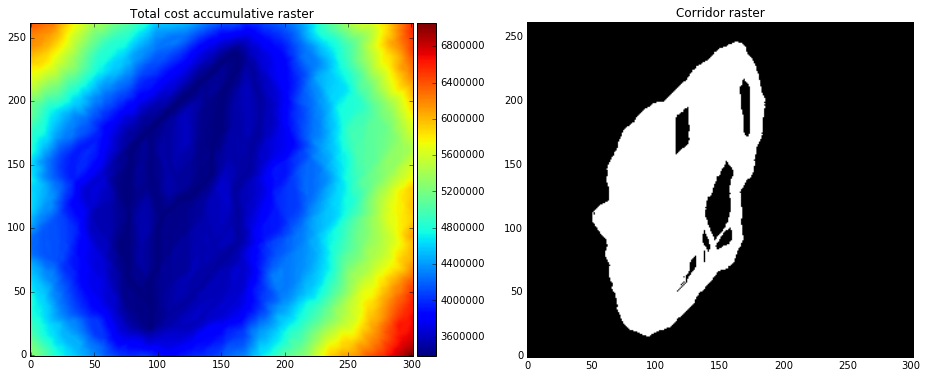

In [42]:
# plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.set_title('Total cost accumulative raster')
im1 = ax1.imshow(costs, cmap='jet')
ax1.invert_yaxis()
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
f.colorbar(im1, cax=cax1, orientation='vertical')

ax2.set_title('Corridor raster')
ax2.imshow(corridor_array, cmap='gray')
ax2.invert_yaxis()